# Análise Estatística de Dados e Informações
**PPCA/UNB**

---

**Tarefa 04**  
**Professor**: João Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matrícula**: 241134680  
**Data da Entrega**: 22/12/2024  
**Github**: https://github.com/aqcorreia/AEDI/tree/bb68c12f3e69d6cafe3fd7d6864e38b4c0721182/Tarefa02

---

**Aplicação**: Regressão Linear

**Dados**: Ames, Iowa (https://www.kaggle.com/datasets/prevek18/ames-housing-dataset)

## 1) Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from scipy.stats import shapiro, kstest
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

## 2) Funções

In [2]:
def calculate_all_correlations(df, target_col):
    """
    Calcula a correlação de todas as colunas com a variável alvo, convertendo colunas não numéricas em números.
    Retorna um DataFrame com os resultados.

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados.
    target_col (str): Nome da coluna da variável dependente.

    Retorna:
    DataFrame: Um DataFrame com duas colunas: 'Coluna' e 'Correlacao'.
    """
    # Lista para armazenar resultados
    results = []

    # Garantir que a coluna alvo é numérica
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        raise ValueError(f"A coluna alvo '{target_col}' precisa ser numérica.")

    # Converter colunas não numéricas para números
    df_encoded = df.copy()
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df_encoded[col]):
            df_encoded[col] = df_encoded[col].astype('category').cat.codes

    # Percorrer todas as colunas do DataFrame
    for col in df_encoded.columns:
        if col != target_col:
            # Calcular correlação, removendo nulos
            correlacao = df_encoded[col].corr(df_encoded[target_col])
            results.append({'Coluna': col, 'Correlacao': correlacao})

     # Criar DataFrame com os resultados e ordenar por correlação descendente
    result_df = pd.DataFrame(results)
    return result_df.sort_values(by='Correlacao', ascending=False).reset_index(drop=True)

In [3]:
def scatter_and_corr(df, col_x, col_y):
    """
    Gera um gráfico de dispersão entre duas colunas de um DataFrame e calcula a correlação entre elas.
    Remove valores nulos antes da análise e exibe o percentual de valores nulos removidos.

    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados.
    col_x (str): Nome da coluna para a variável explicativa.
    col_y (str): Nome da coluna para a variável dependente.
    """
    # Verificar e exibir o percentual de valores nulos
    nulos_x = df[col_x].isnull().sum() / len(df) * 100
    nulos_y = df[col_y].isnull().sum() / len(df) * 100
    print(f'Percentual de valores nulos em {col_x}: {nulos_x:.2f}%')
    print(f'Percentual de valores nulos em {col_y}: {nulos_y:.2f}%')

    # Remover valores nulos
    df = df[[col_x, col_y]].dropna()

    # Gráfico de dispersão
    # plt.scatter(df[col_x], df[col_y], color='blue')
    sns.lmplot(x=col_x, y=col_y, data=df, aspect=2, height=6)
    plt.xlabel(f'Variável Explicativa ({col_x})')
    plt.ylabel(f'Variável Dependente ({col_y})')
    plt.title('Gráfico de Dispersão')
    plt.show()

    # Calcular correlação
    correlacao = df[col_x].corr(df[col_y])
    print(f'Correlação entre {col_x} e {col_y}: {correlacao}')


In [4]:
def gerar_boxplot_e_outliers(df, coluna):
    """
    Gera um boxplot para uma coluna específica de um DataFrame e identifica possíveis outliers.
    
    Parâmetros:
        df (DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna a ser analisada.
    
    Retorna:
        tuple: Limite inferior, limite superior e uma lista de outliers detectados.
    """
    # Calcular Q1, Q3 e IQR
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir limites para outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)][coluna]
    
    # Gerar o boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[coluna], orient='h')
    plt.title(f'Boxplot de {coluna}')
    plt.xlabel(coluna)
    plt.axvline(limite_inferior, color='red', linestyle='--', label='Limite Inferior')
    plt.axvline(limite_superior, color='green', linestyle='--', label='Limite Superior')
    plt.legend()
    plt.show()

    print(f"Limite Inferior: {limite_inferior}")
    print(f"Limite Superior: {limite_superior}")
    print(f"Outliers qtde: {len(outliers)}")
    print(f"Outliers: {outliers.head(5)}")

In [5]:
def avaliar_modelo_regressao(dataframe, variaveis_independentes, variavel_dependente, test_size=0.2, random_state=42):
    resultados = []

    for variavel in variaveis_independentes:
        X = dataframe[[variavel]]
        y = dataframe[variavel_dependente]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        X_train_const = sm.add_constant(X_train)
        X_test_const = sm.add_constant(X_test)

        modelo = sm.OLS(y_train, X_train_const).fit()

        y_pred_train = modelo.predict(X_train_const)
        y_pred_test = modelo.predict(X_test_const)

        r2_treino = r2_score(y_train, y_pred_train)
        r2_teste = r2_score(y_test, y_pred_test)
        rmse_teste = root_mean_squared_error(y_test, y_pred_test)

        coeficientes = modelo.params.iloc[1]  # Coeficiente da variável
        intercepto = modelo.params.iloc[0]  # Intercepto

        resultados.append({
            'Variavel': variavel,
            'Coeficientes': coeficientes,
            'Intercepto': intercepto,
            'R2_treino': r2_treino,
            'R2_teste': r2_teste,
            'RMSE_teste': rmse_teste
        })

    X = dataframe[variaveis_independentes]
    y = dataframe[variavel_dependente]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    modelo = sm.OLS(y_train, X_train_const).fit()

    y_pred_train = modelo.predict(X_train_const)
    y_pred_test = modelo.predict(X_test_const)

    r2_treino = r2_score(y_train, y_pred_train)
    r2_teste = r2_score(y_test, y_pred_test)
    rmse_teste = root_mean_squared_error(y_test, y_pred_test)

    coeficientes = modelo.params.iloc[1:]  # Coeficientes das variáveis
    intercepto = modelo.params.iloc[0]  # Intercepto

    resultados.append({
        'Variavel': 'Todas',
        'Coeficientes': coeficientes.tolist(),
        'Intercepto': intercepto,
        'R2_treino': r2_treino,
        'R2_teste': r2_teste,
        'RMSE_teste': rmse_teste
    })

    print(modelo.summary())

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Previstos")
    plt.title("Valores Reais vs. Valores Previstos")
    plt.show()

    resultados_df = pd.DataFrame(resultados)
    return resultados_df


In [6]:
def validar_modelo(dataframe, variaveis_independentes, variavel_dependente, modelo, cv=5):
    X = dataframe[variaveis_independentes]
    y = dataframe[variavel_dependente]

    # Scorer para RMSE usando a nova função
    rmse_scorer = make_scorer(root_mean_squared_error)

    # Validação cruzada para R^2
    r2_scores = cross_val_score(modelo, X, y, cv=cv, scoring='r2')

    # Validação cruzada para RMSE
    rmse_scores = cross_val_score(modelo, X, y, cv=cv, scoring=rmse_scorer)

    print(f"R² Médio (CV): {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"RMSE Médio (CV): {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

    return {
        'R2_medio': np.mean(r2_scores),
        'R2_desvio': np.std(r2_scores),
        'RMSE_medio': np.mean(rmse_scores),
        'RMSE_desvio': np.std(rmse_scores)
    }

In [57]:
def analisar_residuos(dataframe, variaveis_independentes, variavel_dependente, test_size=0.2, random_state=42):
    # Divisão dos dados em treino e teste
    X = dataframe[variaveis_independentes]
    y = dataframe[variavel_dependente]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Adiciona constante para o termo intercepto
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Ajuste do modelo de regressão linear com statsmodels
    modelo = sm.OLS(y_train, X_train_const).fit()

    # Previsões no conjunto de teste
    y_pred_test = modelo.predict(X_test_const)

    # Resíduos do modelo
    residuos = y_test - y_pred_test

    # Histograma dos resíduos
    plt.figure(figsize=(8, 5))
    sns.histplot(residuos, kde=True)
    plt.title("Histograma dos Resíduos")
    plt.show()

    # QQ-Plot
    stats.probplot(residuos, dist="norm", plot=plt)
    plt.title("QQ-Plot dos Resíduos")
    plt.show()

    # Retorna resíduos, y_test, y_pred_test e a constante
    return residuos, y_test, y_pred_test, X_test_const, X_train, y_train, modelo


## 3) Leitura do arquivo AmesHousing.csv

In [8]:
diretorio = './dados'
ames_housing_data = pd.read_csv(f'{diretorio}/AmesHousing.csv', delimiter=',')

ames_housing_data.shape


(2930, 82)

## 4) Análise exploratória

In [9]:
ames_housing_data.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
ames_housing_data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

## 5) Análise, seleção e tratamento das características

### 5.1) Verifica as correlações de todas as colunas

In [11]:
df_result = calculate_all_correlations(ames_housing_data, 'SalePrice')

In [12]:
df_result.head(10)

,Coluna,Correlacao
0,Overall Qual,0.799262
1,Gr Liv Area,0.706780
2,Garage Cars,0.647877
3,Garage Area,0.640401
4,Total Bsmt SF,0.632280
5,1st Flr SF,0.621676
6,Year Built,0.558426
7,Full Bath,0.545604
8,Year Remod/Add,0.532974
9,Garage Yr Blt,0.526965


### 5.2) Analisa as 6 características que apresentaram maior correlação com o preço

Percentual de valores nulos em Overall Qual: 0.00%
Percentual de valores nulos em SalePrice: 0.00%


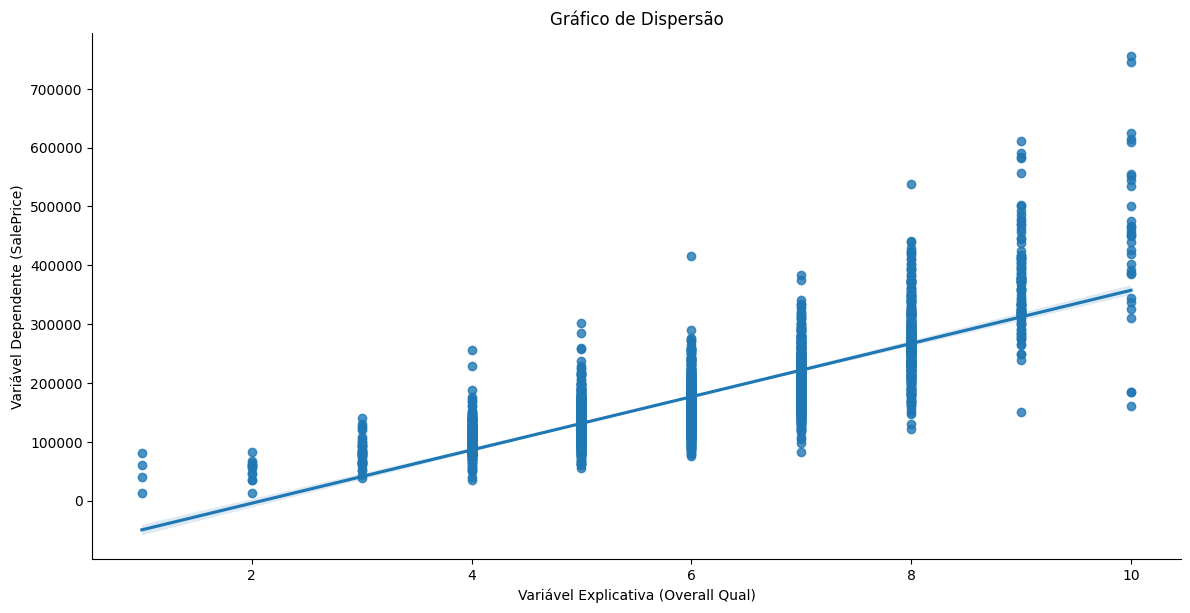

Correlação entre Overall Qual e SalePrice: 0.7992617947690218
Percentual de valores nulos em Gr Liv Area: 0.00%
Percentual de valores nulos em SalePrice: 0.00%


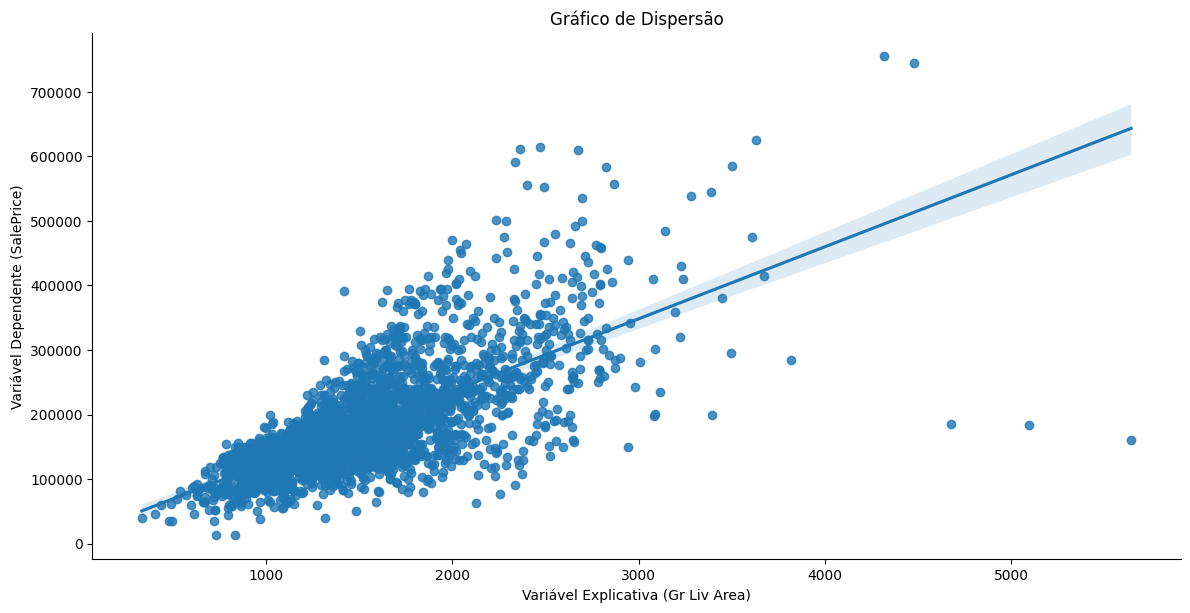

Correlação entre Gr Liv Area e SalePrice: 0.706779920976628
Percentual de valores nulos em Garage Cars: 0.03%
Percentual de valores nulos em SalePrice: 0.00%


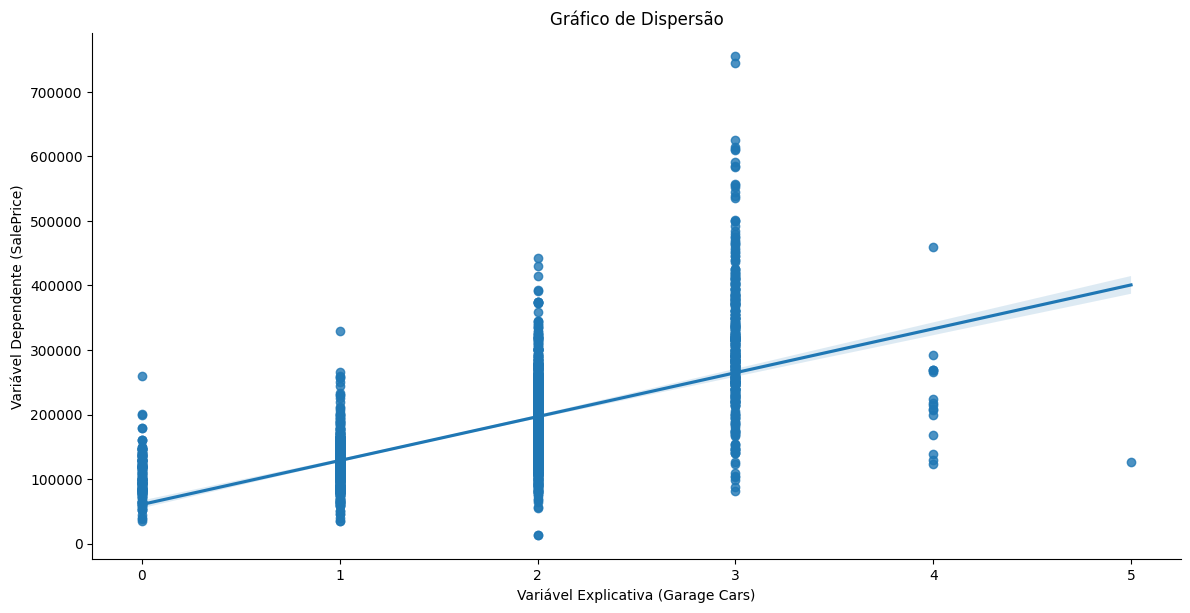

Correlação entre Garage Cars e SalePrice: 0.6478765953956603
Percentual de valores nulos em Total Bsmt SF: 0.03%
Percentual de valores nulos em SalePrice: 0.00%


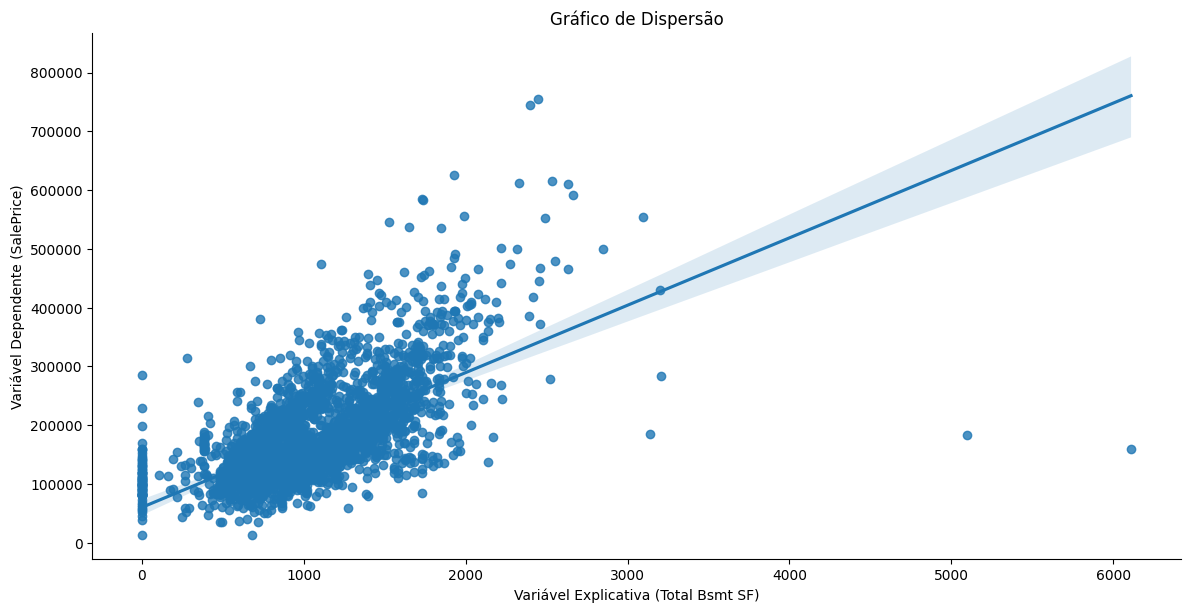

Correlação entre Total Bsmt SF e SalePrice: 0.6322804571065125
Percentual de valores nulos em 1st Flr SF: 0.00%
Percentual de valores nulos em SalePrice: 0.00%


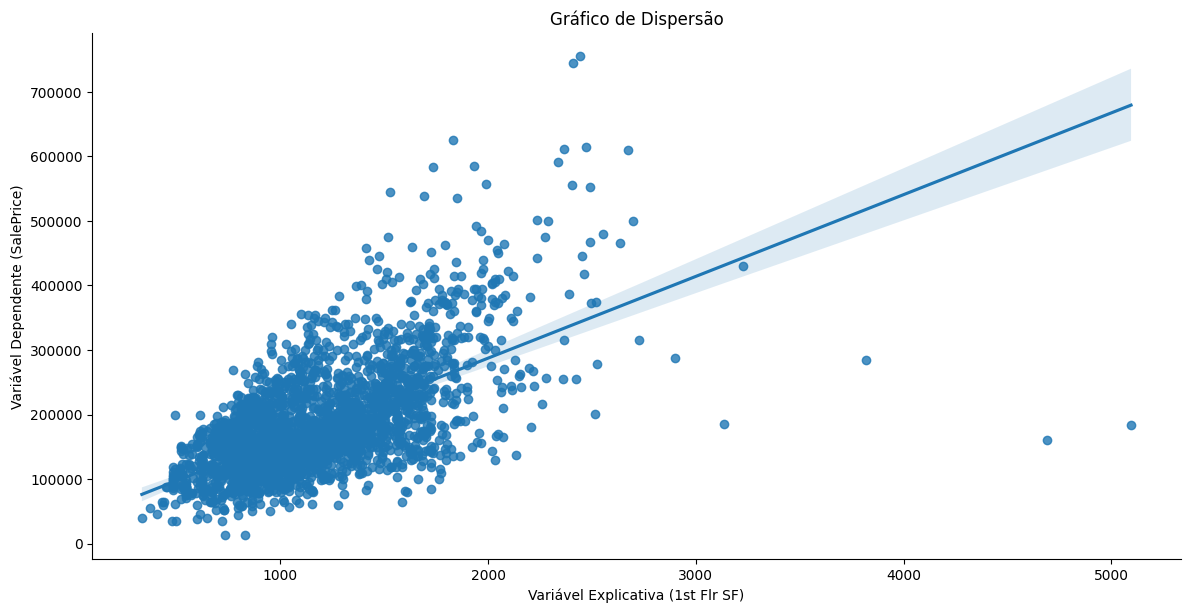

Correlação entre 1st Flr SF e SalePrice: 0.6216760632702534


In [13]:
# Qualidade geral dos materiais e acabamento
scatter_and_corr(ames_housing_data, 'Overall Qual', 'SalePrice')

# Área total acima do nível do solo (área habitável em pés quadrados).
scatter_and_corr(ames_housing_data, 'Gr Liv Area', 'SalePrice')

# Capacidade da garagem em número de carros.
scatter_and_corr(ames_housing_data, 'Garage Cars', 'SalePrice')

# Área total do porão (acabada + não acabada).
scatter_and_corr(ames_housing_data, 'Total Bsmt SF', 'SalePrice')

# Área do primeiro andar (em pés quadrados).
scatter_and_corr(ames_housing_data, '1st Flr SF', 'SalePrice')

In [14]:
ames_housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'SalePrice' ]].describe()

,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,1st Flr SF,SalePrice
count,2930.000000,2930.000000,2929.000000,2929.000000,2930.000000,2930.000000
mean,6.094881,1499.690444,1.766815,1051.614544,1159.557679,180796.060068
std,1.411026,505.508887,0.760566,440.615067,391.890885,79886.692357
min,1.000000,334.000000,0.000000,0.000000,334.000000,12789.000000
25%,5.000000,1126.000000,1.000000,793.000000,876.250000,129500.000000
50%,6.000000,1442.000000,2.000000,990.000000,1084.000000,160000.000000
75%,7.000000,1742.750000,2.000000,1302.000000,1384.000000,213500.000000
max,10.000000,5642.000000,5.000000,6110.000000,5095.000000,755000.000000


#### 5.2.1) Identificação de Outliers

As variáveis **Gr Liv Area**, **Total Bsmt SF** e **1st Flr SF** apresentam valores máximos muito superiores ao percentil 75, sugerindo a presença de outliers que devem ser analisados antes de prosseguir com a modelagem.


##### 5.2.1.1) Gr Liv Area

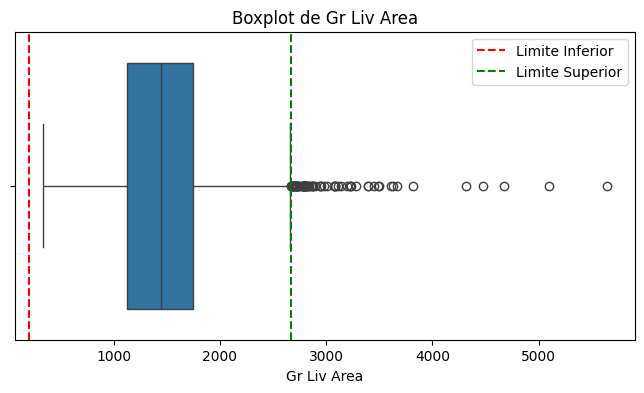

Limite Inferior: 200.875
Limite Superior: 2667.875
Outliers qtde: 75
Outliers: 15     3279
46     2696
65     3238
160    2978
253    3222
Name: Gr Liv Area, dtype: int64


In [15]:
gerar_boxplot_e_outliers(ames_housing_data, 'Gr Liv Area')

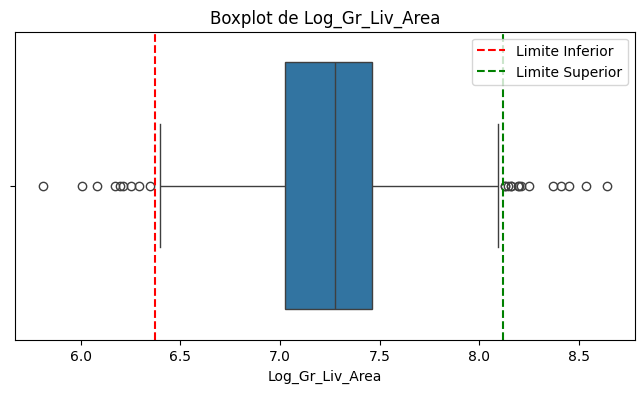

Limite Inferior: 6.371237661509399
Limite Superior: 8.118408720683364
Outliers qtde: 23
Outliers: 302     6.291569
907     6.082219
943     6.349139
1302    6.008813
1306    8.158516
Name: Log_Gr_Liv_Area, dtype: float64


In [16]:
ames_housing_data['Log_Gr_Liv_Area'] = np.log(ames_housing_data['Gr Liv Area'])
gerar_boxplot_e_outliers(ames_housing_data, 'Log_Gr_Liv_Area')

---
A aplicação da transformação logarítmica na variável **Gr Liv Area** resultou em uma redução significativa no número de outliers identificados. Inicialmente, 75 registros foram detectados como outliers na escala original. Após a transformação logarítmica, esse número caiu para 23 registros.

Essa redução indica que a transformação melhorou a distribuição da variável, tornando-a mais simétrica e adequada para análise em uma regressão linear. 

---


##### 5.2.1.2) Total Bsmt SF

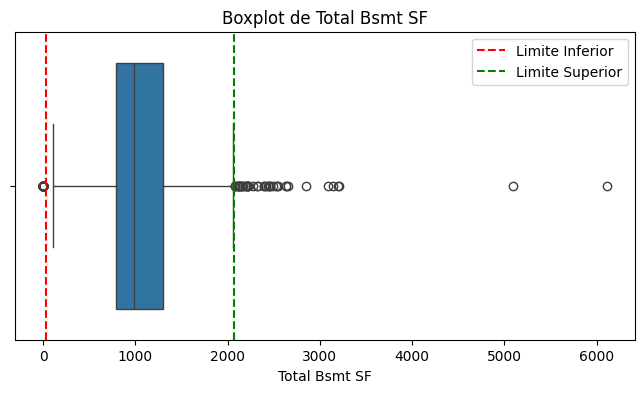

Limite Inferior: 29.5
Limite Superior: 2065.5
Outliers qtde: 123
Outliers: 3      2110.0
44     2330.0
46     2846.0
83        0.0
154       0.0
Name: Total Bsmt SF, dtype: float64


In [17]:
gerar_boxplot_e_outliers(ames_housing_data, 'Total Bsmt SF')

In [18]:
# Contar registros com valor 0 na coluna 'Total Bsmt SF'
zeros_total_bsmt_sf = (ames_housing_data['Total Bsmt SF'] == 0).sum()

print(f"Número de registros com 0 em 'Total Bsmt SF': {zeros_total_bsmt_sf}")


Número de registros com 0 em 'Total Bsmt SF': 79


In [19]:
ames_housing_data['Has_Basement'] = (ames_housing_data['Total Bsmt SF'] > 0).astype(int)

---

Casas sem porão possuem dinâmicas distintas de precificação, onde fatores como área construída e qualidade geral podem ter maior influência no preço final. Para focar exclusivamente no impacto do tamanho do porão sobre o preço, a análise de regressão linear considerará apenas as casas que possuem porão.

---

##### 5.2.1.3) 1st Flr SF

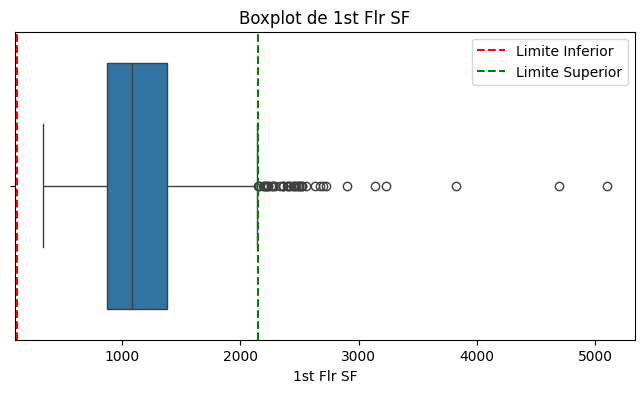

Limite Inferior: 114.625
Limite Superior: 2145.625
Outliers qtde: 43
Outliers: 44     2364
46     2696
136    2207
349    2522
366    2234
Name: 1st Flr SF, dtype: int64


In [20]:
gerar_boxplot_e_outliers(ames_housing_data, '1st Flr SF')

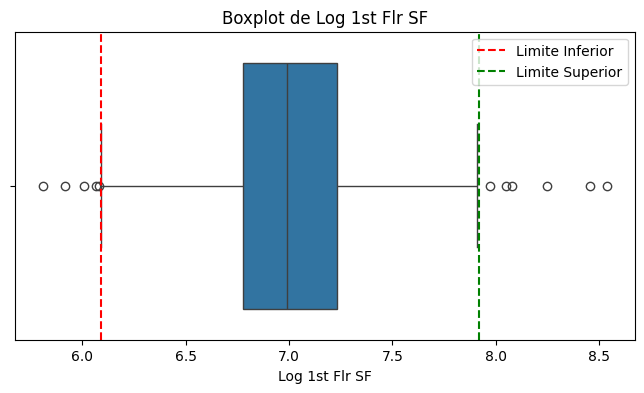

Limite Inferior: 6.090028586471928
Limite Superior: 7.9183558660010265
Outliers qtde: 11
Outliers: 206     5.918894
907     6.082219
1302    6.008813
1497    8.248006
1498    8.453614
Name: Log 1st Flr SF, dtype: float64


In [21]:
ames_housing_data['Log 1st Flr SF'] = np.log(ames_housing_data['1st Flr SF'])
gerar_boxplot_e_outliers(ames_housing_data, 'Log 1st Flr SF')

---
A aplicação da transformação logarítmica na variável **1st Flr SF** resultou em uma redução significativa no número de outliers identificados. Inicialmente, 43 registros foram detectados como outliers na escala original. Após a transformação logarítmica, esse número caiu para 11 registros.

Essa redução indica que a transformação melhorou a distribuição da variável, tornando-a mais simétrica e adequada para análise em uma regressão linear.

---

#### 5.2.2) Verifica se as variáveis selecionadas possuem multicolinearidade

In [22]:
corr_matrix = ames_housing_data[['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'SalePrice']].corr()
corr_matrix

,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,1st Flr SF,SalePrice
Overall Qual,1.000000,0.570556,0.599545,0.547294,0.477837,0.799262
Gr Liv Area,0.570556,1.000000,0.488829,0.444675,0.562166,0.706780
Garage Cars,0.599545,0.488829,1.000000,0.437608,0.439458,0.647877
Total Bsmt SF,0.547294,0.444675,0.437608,1.000000,0.800720,0.632280
1st Flr SF,0.477837,0.562166,0.439458,0.800720,1.000000,0.621676
SalePrice,0.799262,0.706780,0.647877,0.632280,0.621676,1.000000


---

#####  Justificativa para Exclusão da Variável `Total Bsmt SF`

A análise da matriz de correlação revelou uma alta correlação entre as variáveis `Total Bsmt SF` e `1st Flr SF` (0.801), indicando um potencial problema de multicolinearidade. Esse alto grau de associação sugere que ambas as variáveis estão capturando informações semelhantes sobre a área total da casa.

Para evitar redundâncias no modelo de regressão linear e garantir coeficientes mais estáveis e interpretáveis, optou-se por excluir a variável `Total Bsmt SF`. A variável `Total Bsmt SF` será mantida no modelo, pois também apresenta uma forte correlação com a variável dependente (`SalePrice`) e oferece uma representação adequada da área total da casa.


---


In [23]:
ames_housing_data[['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF', 'SalePrice' ]].describe()

,Overall Qual,Log_Gr_Liv_Area,Garage Cars,Log 1st Flr SF,SalePrice
count,2930.000000,2930.000000,2929.000000,2930.000000,2930.000000
mean,6.094881,7.260128,1.766815,7.003309,180796.060068
std,1.411026,0.324688,0.760566,0.322686,79886.692357
min,1.000000,5.811141,0.000000,5.811141,12789.000000
25%,5.000000,7.026427,1.000000,6.775651,129500.000000
50%,6.000000,7.273786,2.000000,6.988413,160000.000000
75%,7.000000,7.463220,2.000000,7.232733,213500.000000
max,10.000000,8.637994,5.000000,8.536015,755000.000000


## 6) Realização da regressão linear

Foi realizada uma análise considerando cada variáve e depois uma regressão linear com todas 'Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF', 'SalePrice']

In [24]:
print(ames_housing_data.shape)
ames_housing_data_reg_linear = ames_housing_data[['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF', 'SalePrice']].dropna()
print(ames_housing_data_reg_linear.shape)


(2930, 85)
(2929, 5)


In [25]:
ames_housing_data_reg_linear.head()

,Overall Qual,Log_Gr_Liv_Area,Garage Cars,Log 1st Flr SF,SalePrice
0,6,7.412160,2.0,7.412160,215000
1,5,6.797940,1.0,6.797940,105000
2,6,7.192182,1.0,7.192182,172000
3,7,7.654443,2.0,7.654443,244000
4,5,7.395722,2.0,6.833032,189900


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1800.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:36:29   Log-Likelihood:                -28071.
No. Observations:                2343   AIC:                         5.615e+04
Df Residuals:                    2338   BIC:                         5.618e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.038e+05   2.41e+04    -

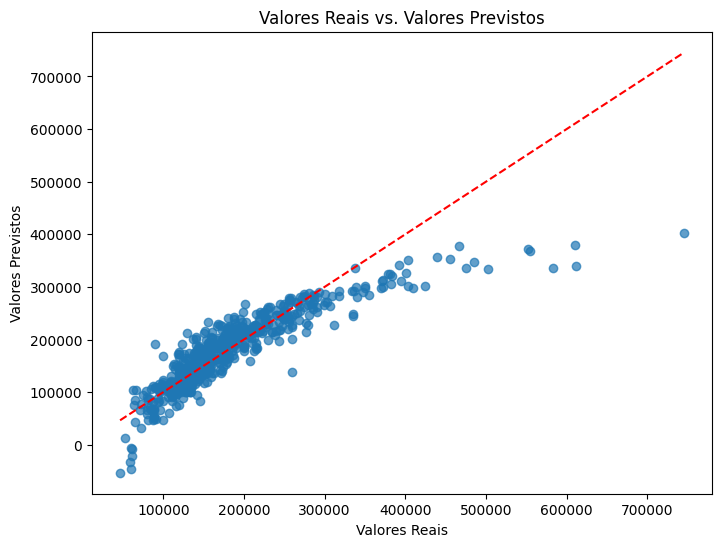

,Variavel,Coeficientes,Intercepto,R2_treino,R2_teste,RMSE_teste
0,Overall Qual,44261.0866,-8.938668e+04,0.639438,0.635094,52436.599631
1,Log_Gr_Liv_Area,165414.12166,-1.020883e+06,0.474948,0.507407,60923.952030
2,Garage Cars,66637.784766,6.250425e+04,0.414217,0.436095,65184.853508
3,Log 1st Flr SF,146182.574977,-8.438846e+05,0.353026,0.406479,66874.710814
4,Todas,"[26990.668729486013, 52839.147330433756, 17377...",-7.037948e+05,0.754887,0.770745,41562.659735


In [26]:
ret = avaliar_modelo_regressao(ames_housing_data_reg_linear, ['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF'], 'SalePrice' )
ret.head(100)

In [27]:
qtedeMaior = len(ames_housing_data_reg_linear[ames_housing_data_reg_linear['SalePrice'] >= 500000])
print(f'Total de propriedade com valor superior à 500.000 = {qtedeMaior}')

Total de propriedade com valor superior à 500.000 = 18


In [28]:
# Filtrando o DataFrame para SalePrice < 500000
ames_housing_data_reg_linear_ate_500000 = ames_housing_data_reg_linear[ames_housing_data_reg_linear['SalePrice'] < 500000]

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     2123.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:36:29   Log-Likelihood:                -27616.
No. Observations:                2328   AIC:                         5.524e+04
Df Residuals:                    2323   BIC:                         5.527e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.192e+05   2.16e+04    -

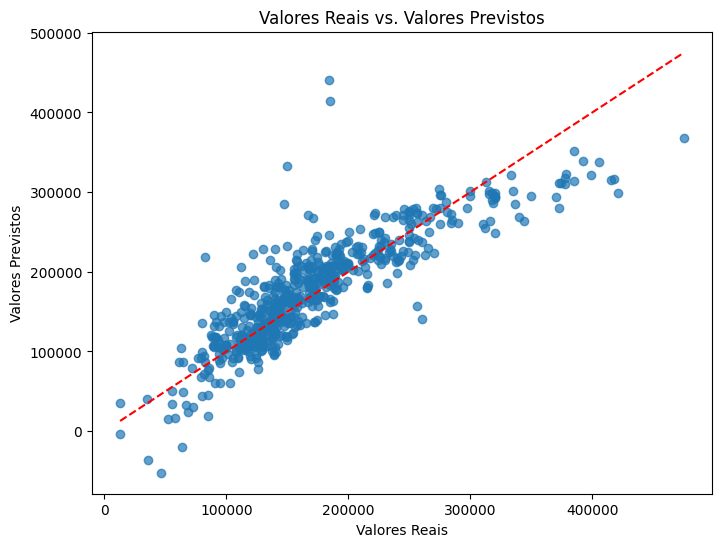

,Variavel,Coeficientes,Intercepto,R2_treino,R2_teste,RMSE_teste
0,Overall Qual,43250.861745,-8.336884e+04,0.654723,0.613185,43593.089419
1,Log_Gr_Liv_Area,163389.153581,-1.005782e+06,0.492494,0.423195,53232.973880
2,Garage Cars,64313.07372,6.687313e+04,0.426655,0.449960,51983.220814
3,Log 1st Flr SF,142107.887198,-8.150160e+05,0.367252,0.301354,58586.100914
4,Todas,"[26090.56105561846, 55080.85831622536, 16462.3...",-7.191893e+05,0.785195,0.719880,37096.928006


In [29]:
ret = avaliar_modelo_regressao(ames_housing_data_reg_linear_ate_500000, ['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF'], 'SalePrice' )
ret.head(100)

In [30]:
valor_coeficientes = ret.loc[4, 'Coeficientes']
print(valor_coeficientes)

[26090.56105561846, 55080.85831622536, 16462.327786202106, 44500.455110200186]


In [31]:
modelo = LinearRegression()

resultados_cv = validar_modelo(
    dataframe=ames_housing_data_reg_linear, 
    variaveis_independentes=['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF'], 
    variavel_dependente='SalePrice', 
    modelo=modelo, 
    cv=5  # Número de folds
)

print(resultados_cv)


R² Médio (CV): 0.7550 ± 0.0250
RMSE Médio (CV): 39306.2620 ± 3321.7400
{'R2_medio': np.float64(0.754968540831272), 'R2_desvio': np.float64(0.02495656847668302), 'RMSE_medio': np.float64(39306.26195247403), 'RMSE_desvio': np.float64(3321.740037424127)}


In [32]:
modelo = LinearRegression()

resultados_cv = validar_modelo(
    dataframe=ames_housing_data_reg_linear_ate_500000, 
    variaveis_independentes=['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF'], 
    variavel_dependente='SalePrice', 
    modelo=modelo, 
    cv=5  # Número de folds
)

print(resultados_cv)

R² Médio (CV): 0.7705 ± 0.0257
RMSE Médio (CV): 34954.9115 ± 1538.8931
{'R2_medio': np.float64(0.7704670018272736), 'R2_desvio': np.float64(0.025726116705532775), 'RMSE_medio': np.float64(34954.91148731795), 'RMSE_desvio': np.float64(1538.8930541879574)}


---

Após a análise inicial, identificou-se que as 18 propriedades mais caras exerciam uma influência desproporcional no modelo de regressão linear, resultando em maior erro médio e menor estabilidade nas métricas. Para mitigar esse problema, foi realizado um ajuste com a remoção dessas propriedades, o que trouxe melhorias significativas no desempenho do modelo.

O modelo sem outliers apresentou um aumento no \(R^2\) de 0.755 para 0.785, indicando maior capacidade de explicar a variância da variável dependente. Além disso, o RMSE médio foi reduzido de 39.306 para 34.954, evidenciando previsões mais precisas e consistentes, com menor desvio padrão. O \(R^2\) treino mede a proporção de variância explicada nos dados de treino, enquanto o \(R^2\) teste avalia a capacidade de generalização do modelo em novos dados. O RMSE (Root Mean Squared Error), por sua vez, mede o erro médio das previsões em unidades da variável dependente, sendo menor um indicador de maior precisão.

Entre as variáveis analisadas no contexto univariado, **Overall Qual** apresentou o maior impacto isolado no modelo com outliers, com um coeficiente de aproximadamente 44.261. Isso indica que, para cada ponto adicional na qualidade geral, o preço de venda (**SalePrice**) aumenta em média 44.261, considerando apenas esta variável. Variáveis como **Log_Gr_Liv_Area** (coeficiente de 165.414) e **Log 1st Flr SF** (coeficiente de 146.183) também demonstraram impactos significativos isolados, sugerindo que o tamanho da área habitável e do primeiro andar têm grande influência no preço de venda. No modelo sem outliers, os coeficientes foram ligeiramente reduzidos, com **Overall Qual** caindo para 43.251, **Log_Gr_Liv_Area** para 163.389 e **Log 1st Flr SF** para 142.108, refletindo uma suavização no impacto das variáveis isoladas.

No contexto multivariado, onde todas as variáveis são consideradas juntas, os coeficientes também mudaram devido à correlação e à interação entre elas. No modelo com outliers, o coeficiente de **Overall Qual** foi de 26.990, enquanto no modelo sem outliers ele diminuiu para 26.091. De forma semelhante, o impacto de **Log_Gr_Liv_Area** aumentou de 52.840 para 55.081 após a remoção dos outliers, indicando maior robustez dessa variável. O \(R^2\) do modelo multivariado sem outliers foi superior (0.785 no treino e 0.720 no teste), enquanto o RMSE diminuiu significativamente para 37.097, destacando a precisão e a estabilidade do modelo ajustado.

### **Outras Métricas do Modelo**
1. **F-statistic**:
   - No modelo com outliers, a \(F\)-statistic foi de **1800**, enquanto no modelo sem outliers ela aumentou para **2123**.
   - Essa métrica avalia se o conjunto das variáveis independentes é estatisticamente significativo para prever a variável dependente. Valores altos e \(p < 0.05\) indicam que o modelo é relevante.
   
2. **Log-Likelihood**:
   - Representa o logaritmo da função de verossimilhança. No modelo com outliers, foi de **-28,071**, enquanto no modelo sem outliers melhorou para **-27,616**.
   - Valores mais altos (menos negativos) indicam que o modelo se ajusta melhor aos dados observados.

3. **AIC (Akaike Information Criterion)**:
   - No modelo com outliers, o AIC foi de **56,150**, enquanto no modelo sem outliers foi reduzido para **55,240**.
   - Métrica que penaliza modelos mais complexos. Valores menores indicam um equilíbrio melhor entre ajuste e complexidade.

4. **BIC (Bayesian Information Criterion)**:
   - O BIC no modelo com outliers foi de **56,180**, enquanto no modelo sem outliers foi reduzido para **55,270**.
   - Assim como o AIC, penaliza a complexidade, mas com peso maior. Valores menores indicam um modelo mais eficiente.

5. **No. Observations**:
   - O número de observações no modelo com outliers foi **2343**, enquanto no modelo sem outliers diminuiu para **2328**, refletindo a remoção das 18 propriedades mais caras.

### **Diagnósticos dos Resíduos**
1. **Durbin-Watson**:
   - Valores de 1.977 (com outliers) e 1.985 (sem outliers) indicam ausência de autocorrelação significativa nos resíduos.

2. **Omnibus e Jarque-Bera**:
   - Ambos os testes rejeitaram a hipótese de normalidade dos resíduos (\(p = 0.000\)) em ambos os modelos.
   - No entanto, o modelo sem outliers apresentou resíduos menos assimétricos e com curtose reduzida.

3. **Skew e Kurtosis**:
   - O modelo com outliers apresentou uma assimetria (\(Skew\)) maior de **0.969** e curtose elevada (\(Kurtosis = 12.710\)), indicando a presença de valores extremos.
   - Após a remoção dos outliers, \(Skew\) foi reduzido para **0.505** e \(Kurtosis\) para **6.500**, melhorando a distribuição dos resíduos.

---

### **Conclusão**
A análise demonstra que, embora variáveis como **Overall Qual** tenham grande impacto no contexto univariado, a remoção dos outliers resultou em um modelo mais estável, com métricas de ajuste melhores e resíduos mais próximos da normalidade. No cenário multivariado, o modelo ajustado sem outliers capturou melhor as interações entre as variáveis, oferecendo previsões mais equilibradas e confiáveis. Métricas como \(R^2\), AIC e BIC, além da análise dos resíduos, confirmam que o modelo sem outliers é mais robusto e eficiente para o conjunto de dados analisado.



---

### 6.1) Validação dos Pressupostos da Regressão Linear

### 6.1.1) Verificação da normalidade dos resíduos

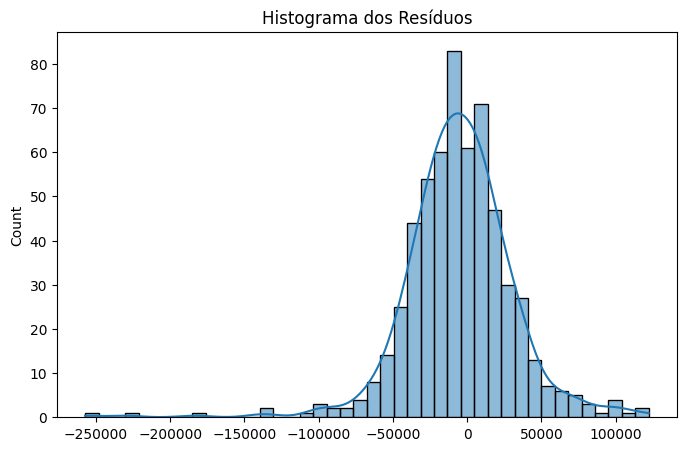

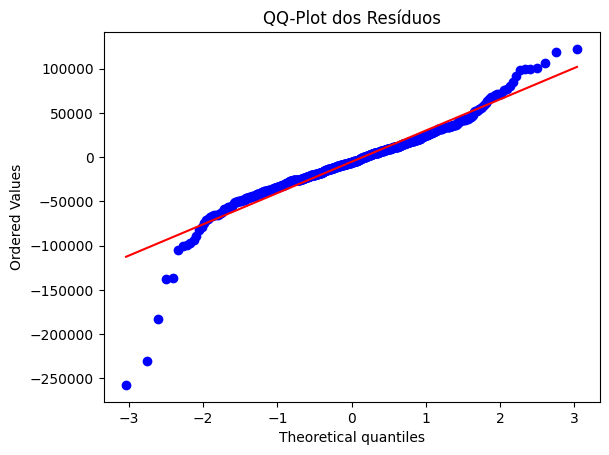

In [58]:
residuos, y_test, y_pred_test, X_test_const, X_train, y_train, modelo =  analisar_residuos(ames_housing_data_reg_linear_ate_500000, ['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF'], 'SalePrice' )


In [40]:
# Realizar o teste de Shapiro-Wilk
stat_shapiro, p_shapiro = shapiro(residuos)
print(f"Teste de Shapiro-Wilk: Estatística={stat_shapiro:.4f}, p-valor={p_shapiro:.4f}")

# Realizar o teste de Kolmogorov-Smirnov
stat_ks, p_ks = kstest(residuos, 'norm', args=(residuos.mean(), residuos.std()))
print(f"Teste de Kolmogorov-Smirnov: Estatística={stat_ks:.4f}, p-valor={p_ks:.4f}")


Teste de Shapiro-Wilk: Estatística=0.9198, p-valor=0.0000
Teste de Kolmogorov-Smirnov: Estatística=0.0730, p-valor=0.0038


### 6.1.2) Verificação da homocedasticidade dos resíduos

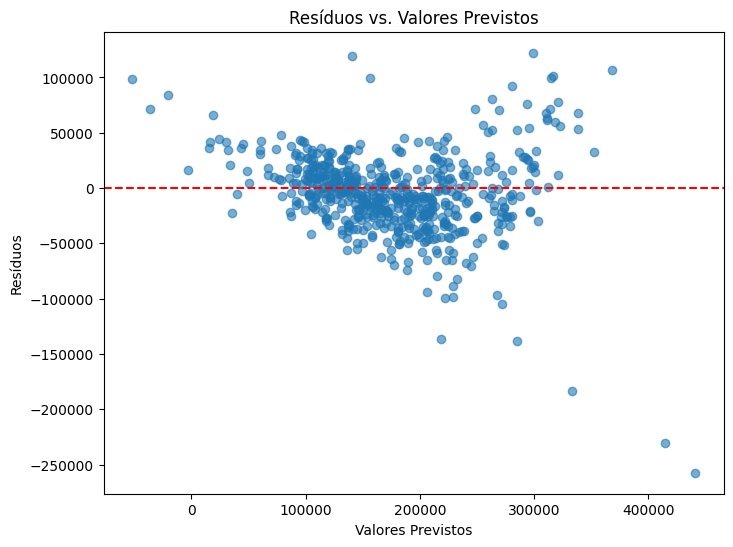

In [41]:
# Gráfico de Resíduos vs. Valores Previstos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs. Valores Previstos")
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.show()


In [42]:
bp_test = het_breuschpagan(residuos, X_test_const)
print(f"Breusch-Pagan: Estatística={bp_test[0]:.4f}, p-valor={bp_test[1]:.4f}")


Breusch-Pagan: Estatística=77.2563, p-valor=0.0000


### 6.1.3) Verificação da multicolinearidade

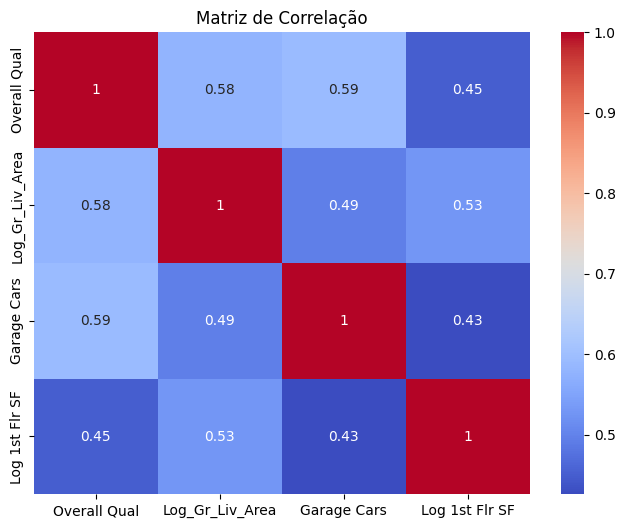

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# Defina as variáveis independentes e adicione a constante
X = sm.add_constant(ames_housing_data_reg_linear_ate_500000[['Overall Qual', 'Log_Gr_Liv_Area', 'Garage Cars', 'Log 1st Flr SF']])

# Calcular o VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exibir os resultados
print(vif_data)


           Feature         VIF
0            const  908.816896
1     Overall Qual    1.875233
2  Log_Gr_Liv_Area    1.805681
3      Garage Cars    1.672693
4   Log 1st Flr SF    1.492008


---

### Análise dos Pressupostos da Regressão Linear

A análise dos resultados da regressão mostra que o modelo apresenta um bom ajuste geral, explicando 78,5% da variância na variável dependente (*SalePrice*), com todas as variáveis independentes sendo estatisticamente significativas (\(p < 0.05\)). Os coeficientes indicam que variáveis como **Overall Qual** (\(+26,090\)), **Log_Gr_Liv_Area** (\(+55,080\)) e **Log 1st Flr SF** (\(+44,500\)) têm impactos significativos no preço de venda, enquanto **Garage Cars** adiciona em média \(+16,460\) ao preço por vaga adicional na garagem.

#### **Normalidade dos Resíduos**
Os resultados do Teste de Shapiro-Wilk (Estatística=0.9198, \(p = 0.0000\)) e do Teste de Kolmogorov-Smirnov (Estatística=0.0730, \(p = 0.0038\)) indicam que os resíduos não seguem uma distribuição normal (\(p < 0.05\)). Essa conclusão é corroborada pelo histograma e pelo QQ-Plot, que mostram leve assimetria e a presença de valores extremos. Embora a normalidade dos resíduos seja um pressuposto menos crítico, sua ausência pode influenciar a precisão das inferências estatísticas.

#### **Homoscedasticidade**
O Teste de Breusch-Pagan (Estatística=77.2563, \(p = 0.0000\)) revelou a presença de heterocedasticidade (\(p < 0.05\)), indicando que a variância dos resíduos não é constante. O gráfico de resíduos vs. valores previstos confirma essa observação, mostrando um padrão em forma de funil. Esse comportamento pode impactar a validade de inferências e sugere que o modelo linear tradicional pode precisar de ajustes para lidar com a variância desigual.

#### **Multicolinearidade**
O cálculo do VIF (Variance Inflation Factor) apresentou valores abaixo de 5 para todas as variáveis independentes, indicando ausência de multicolinearidade significativa. A matriz de correlação confirma correlações moderadas (e.g., \(r = 0.58\) entre **Overall Qual** e **Log_Gr_Liv_Area**) e sem problemas graves (\(r > 0.8\)).

Apesar das violações nos pressupostos de normalidade e homocedasticidade, **a regressão linear tradicional ainda pode ser utilizada para fins preditivos**. No entanto, para melhorar a robustez do modelo, foi realizada uma regressão ajustada com erros padrão robustos (HC3), que corrige os problemas relacionados à heterocedasticidade, garantindo maior confiabilidade nas inferências estatísticas e mantendo a validade do modelo.


---

In [60]:
modelo_robusto = modelo.get_robustcov_results(cov_type='HC3')
print(modelo_robusto.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     967.1
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:19:44   Log-Likelihood:                -27616.
No. Observations:                2328   AIC:                         5.524e+04
Df Residuals:                    2323   BIC:                         5.527e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.192e+05   3.23e+04    -

---

A análise dos resultados da regressão ajustada com erros padrão robustos (HC3) mostra que o modelo apresenta um bom ajuste geral, explicando 78,5% da variância na variável dependente (*SalePrice*), com todas as variáveis independentes sendo estatisticamente significativas (\(p < 0.05\)). Os coeficientes indicam que variáveis como **Overall Qual** (\(+26,090\)), **Log_Gr_Liv_Area** (\(+55,080\)), e **Log 1st Flr SF** (\(+44,500\)) têm impactos significativos no preço de venda, enquanto **Garage Cars** adiciona em média \(+16,460\) ao preço por vaga adicional na garagem.

Os erros padrão ajustados, destacados na seção de *Notes* ("Standard Errors are heteroscedasticity robust"), garantem a validade estatística dos coeficientes, mesmo que o pressuposto de homocedasticidade tenha sido violado. No entanto, os diagnósticos dos resíduos indicam que eles não seguem uma distribuição normal (\(p < 0.0001\)), conforme os testes Omnibus e Jarque-Bera. Apesar dessas violações, o modelo continua adequado para predições, e os erros padrão robustos corrigem possíveis distorções nas inferências. 

---